In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline
from keras.applications.imagenet_utils import preprocess_input

In [2]:
ROOT_DIR = "C:/Users/jpsha/Documents/capstone/datasets/2_genral-cnn/colonDataSet"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
number_of_images.items()

dict_items([('no', 10), ('yes', 10)])

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

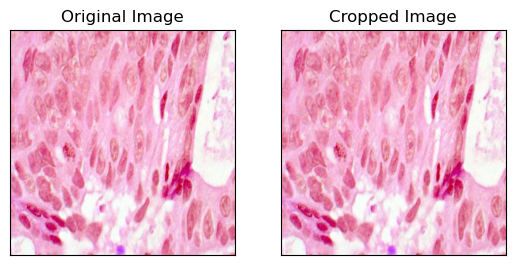

In [5]:
ex_img = cv2.imread("C:/Users/jpsha/Documents/capstone/test/yes/colonca6.jpeg")
ex_new_img = crop_brain_contour(ex_img, True)

In [7]:
os.listdir("C:/Users/jpsha/Documents/capstone/datasets/2_genral-cnn/colonDataSet")

['no', 'yes']

In [8]:
def dataFolder(p,split):
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                       size = (math.floor(split*number_of_images[dir])-5),
                                        replace = False
                                       ):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("./"+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"{p}Folder exist")

In [9]:
dataFolder("train",0.7)

trainFolder exist


In [10]:
dataFolder("val",0.15)

valFolder exist


In [11]:
dataFolder("test",0.15)

testFolder exist


In [12]:
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
number_of_images.items()

dict_items([('no', 10), ('yes', 10)])

In [13]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D

In [14]:
from keras.models import Sequential
import keras

In [15]:
# from tensorflow.keras.utils import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [16]:
from tensorflow.keras.utils import img_to_array 

In [17]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))


model.add(Conv2D(filters=36, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128 , kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))
model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [18]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [19]:
def preprocessingImages1(path):
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True)
    image = image_data.flow_from_directory(path, target_size=(224,224),batch_size=32,class_mode = 'binary')
    return image

In [20]:
path = "C:/Users/jpsha/Documents/capstone/train"
train_data = preprocessingImages1(path)

Found 6990 images belonging to 2 classes.


In [21]:
def preprocessingImages2(path):
    image_data = ImageDataGenerator(rescale=1/255) 
    image = image_data.flow_from_directory(path, target_size=(224,224),batch_size=32, class_mode='binary')
    return image

In [22]:
path = "C:/Users/jpsha/Documents/capstone/test"
test_data = preprocessingImages2(path)

Found 1490 images belonging to 2 classes.


In [23]:
path = "C:/Users/jpsha/Documents/capstone/val"
val_data = preprocessingImages2(path)

Found 1490 images belonging to 2 classes.


In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=6, verbose=1,mode='auto')

mc = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5",verbose=1, save_best_only=True, mode='auto')

cd = [es,mc]

In [25]:
hs = model.fit_generator(generator=train_data, steps_per_epoch=8, epochs=30, verbose=1, validation_data=val_data, validation_steps=16, callbacks = cd)

C:\Users\jpsha\AppData\Local\Temp\ipykernel_26508\2398018014.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs = model.fit_generator(generator=train_data, steps_per_epoch=8, epochs=30, verbose=1, validation_data=val_data, validation_steps=16, callbacks = cd)


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.4805
Epoch 1: val_accuracy improved from -inf to 0.48633, saving model to .\bestmodel.h5
8/8 [==============================] - 24s 3s/step - loss: 0.7958 - accuracy: 0.4805 - val_loss: 0.6970 - val_accuracy: 0.4863
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5195
Epoch 2: val_accuracy improved from 0.48633 to 0.50000, saving model to .\bestmodel.h5
8/8 [==============================] - 23s 3s/step - loss: 0.6924 - accuracy: 0.5195 - val_loss: 0.7153 - val_accuracy: 0.5000
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5391
Epoch 3: val_accuracy improved from 0.50000 to 0.52930, saving model to .\bestmodel.h5
8/8 [==============================] - 23s 3s/step - loss: 0.6935 - accuracy: 0.5391 - val_loss: 0.6919 - val_accuracy: 0.5293
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 

In [26]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

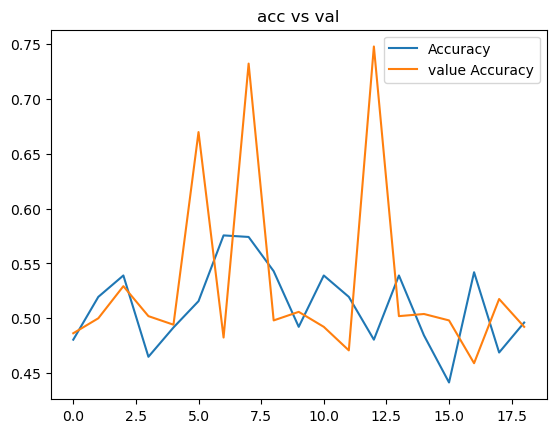

In [27]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'], label='Accuracy')
plt.plot(h['val_accuracy'], label='value Accuracy')
plt.legend()
plt.title("acc vs val")
plt.show()

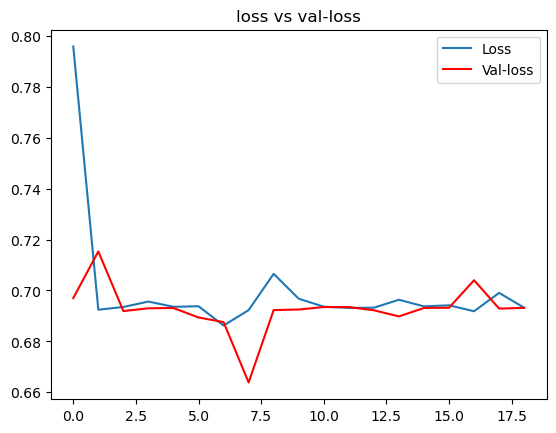

In [28]:
import matplotlib.pyplot as plt
plt.plot(h['loss'], label='Loss')
plt.plot(h['val_loss'],c="red", label='Val-loss')
plt.legend()
plt.title("loss vs val-loss")
plt.show()

In [29]:
from keras.models import load_model
model = load_model("C:/Users/jpsha/Documents/capstone/bestmodel.h5")

In [30]:
acc = model.evaluate_generator(test_data)[1]
print(f"the accuracy of our model is {acc * 100} %")

C:\Users\jpsha\AppData\Local\Temp\ipykernel_26508\3312268435.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(test_data)[1]


the accuracy of our model is 75.03355741500854 %


In [31]:
from tensorflow.keras.utils import load_img

In [32]:
from tensorflow.keras.utils import img_to_array

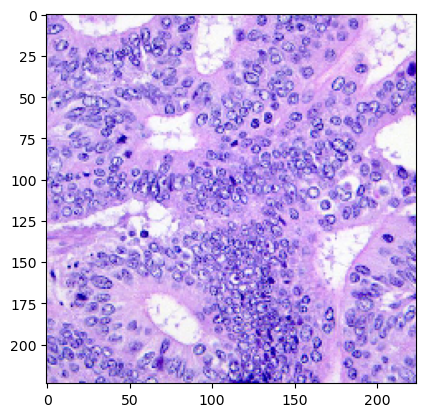

1/1 [==============================] - 0s 153ms/step
This image doesnt colon cancer


In [34]:
path = "C:/Users/jpsha/Documents/capstone/colonDataSet/yes/colonca2963.jpeg"
img = load_img(path, target_size=(224,224))
input_arr = img_to_array(img)/255
plt.imshow(input_arr)
plt.show()
input_arr.shape

input_arr = np.expand_dims(input_arr, axis=0)
# pred = model.predict_classes(input_arr)[0][0]
pred = (model.predict(input_arr) > 0.5).astype("int32")
pred

if pred == 0:
    print('This image doesnt colon cancer')
else:
    print('This image has colon cancer')

In [35]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [36]:
model.metrics_names

['loss', 'accuracy']